In [1]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
# !unzip bank+marketing.zip 
# !unzip bank.zip

In [1]:
# !pip install tqdm
from collections import Counter
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')

names = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

df = df[names]


In [3]:
from sklearn.model_selection import train_test_split
seed = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state= seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

assert len(df) == len(df_train) + len(df_val) + len(df_test)

In [4]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# save the target variable
y_train = (df_train.y == 'yes').values
y_val = (df_val.y == 'yes').values
y_test = (df_test.y == 'yes').values

# drop the target variable
del df_train['y']
del df_val['y']
del df_test['y']

### Q1 ROC AUC

In [7]:
df_q1 = df_train.select_dtypes(include=np.number)

In [9]:
from sklearn.metrics import roc_auc_score

auc_scores = {}

for col in tqdm(df_q1.columns):
    auc = roc_auc_score(y_train, df_q1[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_q1[col])
    auc_scores[col] = round(auc,3)

auc_scores = dict(sorted(auc_scores.items(), key=lambda x: x[1], reverse=True))
auc_scores

100%|██████████| 7/7 [00:00<00:00, 157.05it/s]


{'duration': 0.815,
 'previous': 0.599,
 'pdays': 0.59,
 'balance': 0.589,
 'campaign': 0.571,
 'day': 0.526,
 'age': 0.512}

### Q2 Training the model

In [ ]:
# Use DictVectorizer to do ONE-HOT encoding for training data
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
# dv.get_feature_names_out()

array(['age', 'balance', 'campaign', 'contact=cellular',
       'contact=telephone', 'contact=unknown', 'day', 'duration',
       'education=primary', 'education=secondary', 'education=tertiary',
       'education=unknown', 'housing=no', 'housing=yes', 'job=admin.',
       'job=blue-collar', 'job=entrepreneur', 'job=housemaid',
       'job=management', 'job=retired', 'job=self-employed',
       'job=services', 'job=student', 'job=technician', 'job=unemployed',
       'job=unknown', 'marital=divorced', 'marital=married',
       'marital=single', 'month=apr', 'month=aug', 'month=dec',
       'month=feb', 'month=jan', 'month=jul', 'month=jun', 'month=mar',
       'month=may', 'month=nov', 'month=oct', 'month=sep', 'pdays',
       'poutcome=failure', 'poutcome=other', 'poutcome=success',
       'poutcome=unknown', 'previous'], dtype=object)

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
# One-hot encoding for validation data
val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

# do the prediction
y_pred = model.predict_proba(X_val)[:, 1]

In [13]:
print('auc socre is: %.3f' %roc_auc_score(y_val, y_pred))

auc socre is: 0.900


### Q3 Precision and Recall

In [18]:
threshold = np.round(np.linspace(0,1,100),2)
scores = []
for t in threshold:
    tp = ((y_pred>=t) & (y_val==1)).sum()
    fp = ((y_pred>=t) & (y_val==0)).sum()
    tn = ((y_pred<t) & (y_val==0)).sum()
    fn = ((y_pred<t) & (y_val==1)).sum()
    precision = round(tp/(tp+fp), 2)
    recall = round(tp/(tp+fn), 2)
    f1 = round( 2*(precision*recall)/(precision+recall) ,2)
    scores.append((t, tp, fp, fn, tn, precision, recall, f1))

df_q3 = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall', 'f1'])
df_q3

/tmp/ipykernel_55427/1388460250.py:8: RuntimeWarning: invalid value encountered in scalar divide
  precision = round(tp/(tp+fp), 2)


,threshold,tp,fp,tn,fn,precision,recall,f1
0,0.00,1098,7944,0,0,0.12,1.00,0.21
1,0.01,1094,7004,4,940,0.14,1.00,0.25
2,0.02,1093,5789,5,2155,0.16,1.00,0.28
3,0.03,1087,4745,11,3199,0.19,0.99,0.32
4,0.04,1068,3800,30,4144,0.22,0.97,0.36
...,...,...,...,...,...,...,...,...
95,0.96,30,17,1068,7927,0.64,0.03,0.06
96,0.97,25,15,1073,7929,0.62,0.02,0.04
97,0.98,21,10,1077,7934,0.68,0.02,0.04
98,0.99,11,5,1087,7939,0.69,0.01,0.02


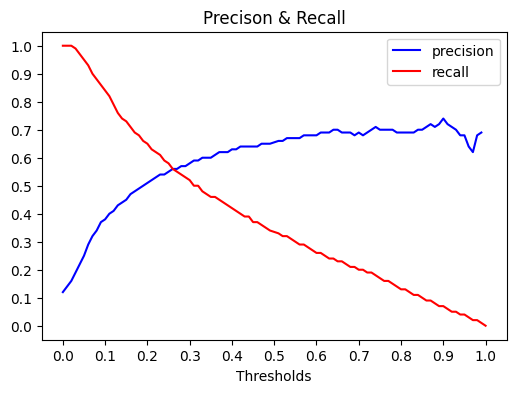

In [16]:
plt.figure(figsize=(6, 4))

plt.plot(df_q3.threshold, df_q3.precision, color='blue', linestyle='solid', label='precision')
plt.plot(df_q3.threshold, df_q3.recall, color='red', linestyle='solid', label='recall')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('Precison & Recall')

plt.show()

### Q4 F1 score

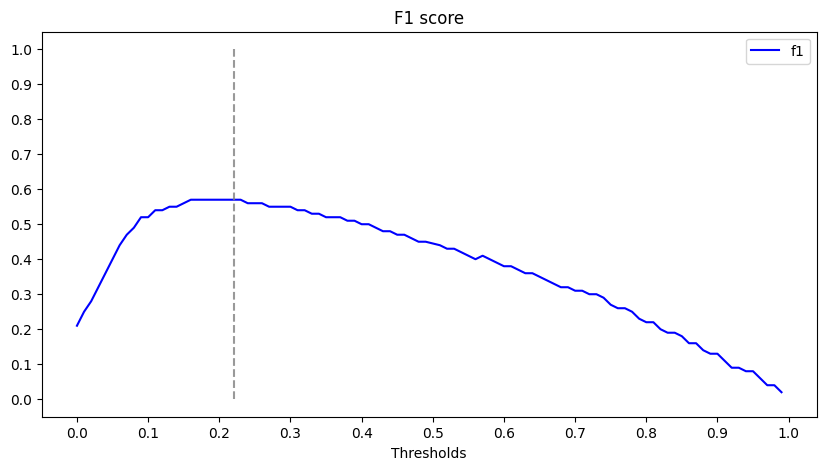

In [23]:
plt.figure(figsize=(10, 5))

plt.plot(df_q3.threshold, df_q3.f1, color='blue', linestyle='solid', label='f1')
plt.vlines(0.22, 0.0, 1, color='grey', linestyle='--', alpha=0.8)
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('F1 score')

plt.show()

### Q5 5-Fold CV

In [25]:
q5 = df_full_train.columns.tolist()
q5.remove('y')

In [26]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[q5].to_dict(orient='records')
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[q5].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [27]:
from sklearn.model_selection import KFold

scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


### Q5 Hyperparameter Tuning

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=   1, 0.906 +- 0.006


### 4.9 Explore more
- Check the precision and recall of the dummy classifier that always predict "FALSE"
- F1 score = 2 P R / (P + R)
- Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
- Area under the PR curve is also a useful metric